# Anomaly Detection in Time Series Pump Sensor Data

Ref: https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Load dataset

In [2]:
PATH_DATA = "data/sensor.csv"
df_data = pd.read_csv(PATH_DATA)


df_data

Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0                0  2018-04-01 00:00:00   2.465394   47.09201  53.211800   
1                1  2018-04-01 00:01:00   2.465394   47.09201  53.211800   
2                2  2018-04-01 00:02:00   2.444734   47.35243  53.211800   
3                3  2018-04-01 00:03:00   2.460474   47.09201  53.168400   
4                4  2018-04-01 00:04:00   2.445718   47.13541  53.211800   
...            ...                  ...        ...        ...        ...   
220315      220315  2018-08-31 23:55:00   2.407350   47.69965  50.520830   
220316      220316  2018-08-31 23:56:00   2.400463   47.69965  50.564240   
220317      220317  2018-08-31 23:57:00   2.396528   47.69965  50.520830   
220318      220318  2018-08-31 23:58:00   2.406366   47.69965  50.520832   
220319      220319  2018-08-31 23:59:00   2.396528   47.69965  50.520832   

        sensor_03   sensor_04  sensor_05  sensor_06  sensor_07  ...  \
0       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
1       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
2       46.397570  638.888900   73.54598   13.32465   16.03733  ...   
3       46.397568  628.125000   76.98898   13.31742   16.24711  ...   
4       46.397568  636.458300   76.58897   13.35359   16.21094  ...   
...           ...         ...        ...        ...        ...  ...   
220315  43.142361  634.722229   64.59095   15.11863   16.65220  ...   
220316  43.142361  630.902771   65.83363   15.15480   16.70284  ...   
220317  43.142361  625.925903   67.29445   15.08970   16.70284  ...   
220318  43.142361  635.648100   65.09175   15.11863   16.56539  ...   
220319  43.142361  639.814800   65.45634   15.11863   16.65220  ...   

        sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  \
0        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
1        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
2        41.66666  39.351852   65.39352   51.21528  38.194443   155.9606   
3        40.88541  39.062500   64.81481   51.21528  38.194440   155.9606   
4        41.40625  38.773150   65.10416   51.79398  38.773150   158.2755   
...           ...        ...        ...        ...        ...        ...   
220315   38.28125  68.287030   52.37268   48.32176  41.087960   212.3843   
220316   38.28125  66.840280   50.63657   48.03241  40.798610   213.8310   
220317   39.06250  65.393520   48.90046   48.03241  40.798610   217.3032   
220318   40.62500  64.236110   47.74306   48.32176  40.509258   222.5116   
220319   41.40625  62.789350   46.29630   48.90046  40.219910   227.4306   

        sensor_49  sensor_50  sensor_51  machine_status  
0        67.70834   243.0556   201.3889          NORMAL  
1        67.70834   243.0556   201.3889          NORMAL  
2        67.12963   241.3194   203.7037          NORMAL  
3        66.84028   240.4514   203.1250          NORMAL  
4        66.55093   242.1875   201.3889          NORMAL  
...           ...        ...        ...             ...  
220315  153.64580        NaN   231.1921          NORMAL  
220316  156.25000        NaN   231.1921          NORMAL  
220317  155.38190        NaN   232.0602          NORMAL  
220318  153.93520        NaN   234.0856          NORMAL  
220319  150.46300        NaN   234.0856          NORMAL  

[220320 rows x 55 columns]

In [3]:
print("Shape: ", df_data.shape, "\n")
df_data.info()

Shape:  (220320, 55) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  

# Clean Data

In [4]:
# Drop unneccessary columns
del df_data['Unnamed: 0']

# Remove duplicate columns
df_data = df_data.drop_duplicates()

# Drop 'sensor_15' since entire column is has no values
del df_data['sensor_15']

# Convert timestamp column into datetime object
df_data['date'] = pd.to_datetime(df_data['timestamp'])
del df_data['timestamp']

In [5]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(df_data)

percent
sensor_50  0.349569
sensor_51  0.069821
sensor_00  0.046333
sensor_07  0.024741
sensor_08  0.023180
sensor_06  0.021777
sensor_09  0.020856
sensor_01  0.001675
sensor_30  0.001185
sensor_29  0.000327
sensor_32  0.000309
sensor_17  0.000209
sensor_18  0.000209
sensor_22  0.000186
sensor_25  0.000163
sensor_16  0.000141
sensor_38  0.000123
sensor_46  0.000123
sensor_49  0.000123
sensor_48  0.000123
sensor_39  0.000123
sensor_40  0.000123
sensor_41  0.000123
sensor_42  0.000123
sensor_43  0.000123
sensor_44  0.000123
sensor_47  0.000123
sensor_45  0.000123
sensor_14  0.000095
sensor_26  0.000091
sensor_10  0.000086
sensor_02  0.000086
sensor_11  0.000086
sensor_12  0.000086
sensor_13  0.000086
sensor_05  0.000086
sensor_03  0.000086
sensor_04  0.000086
sensor_27  0.000073
sensor_19  0.000073
sensor_20  0.000073
sensor_21  0.000073
sensor_23  0.000073
sensor_24  0.000073
sensor_28  0.000073
sensor_31  0.000073
sensor_33  0.000073
sensor_34  0.000073
sensor_35  0.000073
sensor_36  0.000073
sensor_37  0.000073

In [6]:
# Fill missing values with mean
df_data = df_data.fillna(df_data.mean())

/home/gagan/PythonEnv/env_deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [7]:
print("Shape: ", df_data.shape, "\n")
df_data.info()

Shape:  (220320, 53) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220320 entries, 0 to 220319
Data columns (total 53 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   sensor_00       220320 non-null  float64       
 1   sensor_01       220320 non-null  float64       
 2   sensor_02       220320 non-null  float64       
 3   sensor_03       220320 non-null  float64       
 4   sensor_04       220320 non-null  float64       
 5   sensor_05       220320 non-null  float64       
 6   sensor_06       220320 non-null  float64       
 7   sensor_07       220320 non-null  float64       
 8   sensor_08       220320 non-null  float64       
 9   sensor_09       220320 non-null  float64       
 10  sensor_10       220320 non-null  float64       
 11  sensor_11       220320 non-null  float64       
 12  sensor_12       220320 non-null  float64       
 13  sensor_13       220320 non-null  float64       
 14  sensor_14    

# Exploratory Data Analysis (EDA)

In [8]:
df_data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

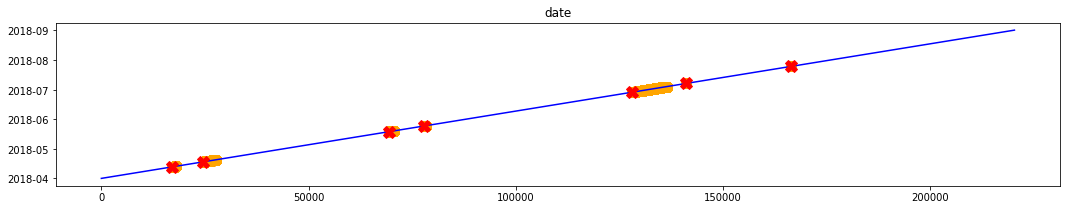

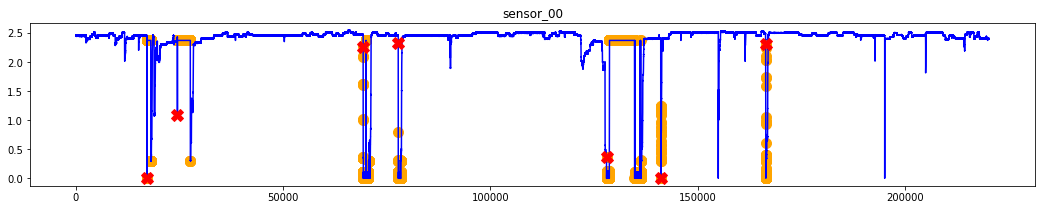

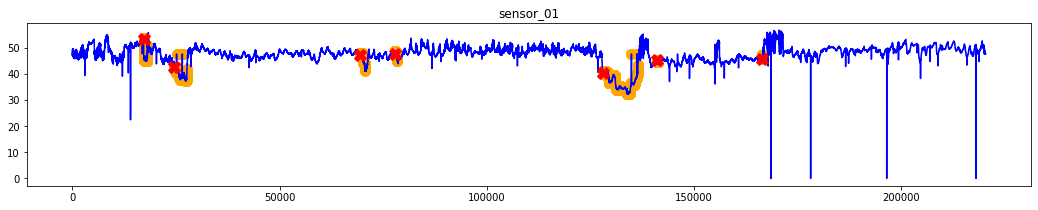

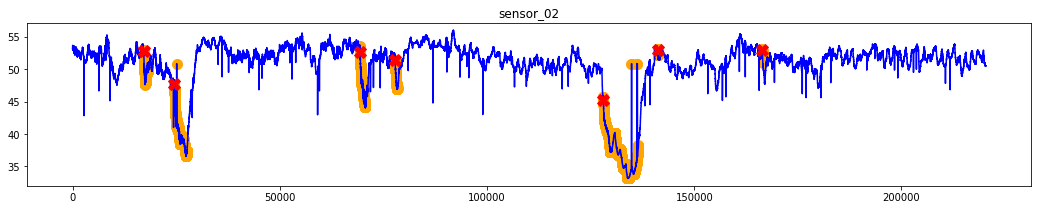

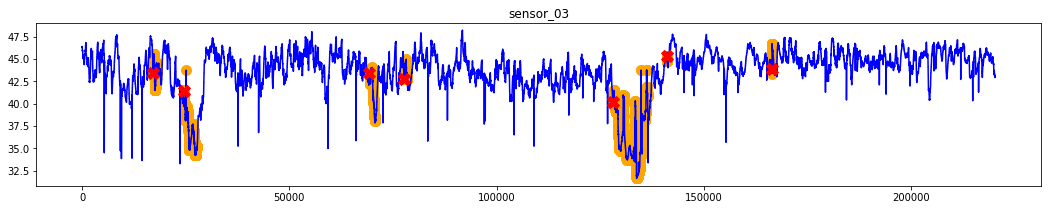

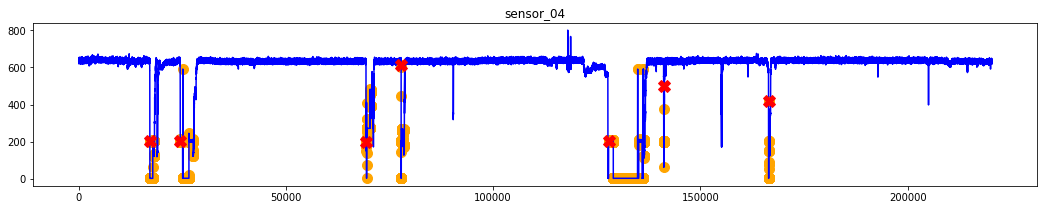

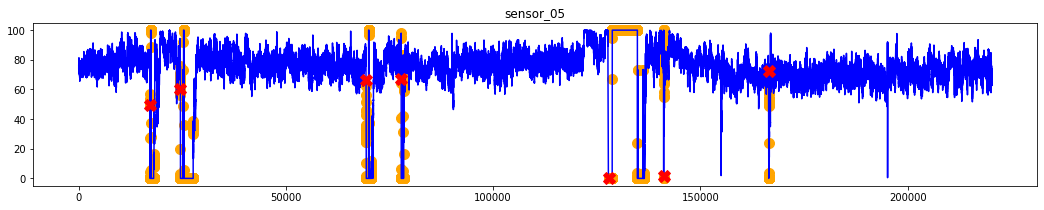

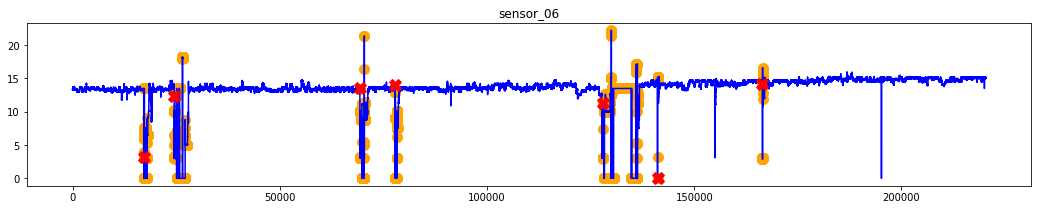

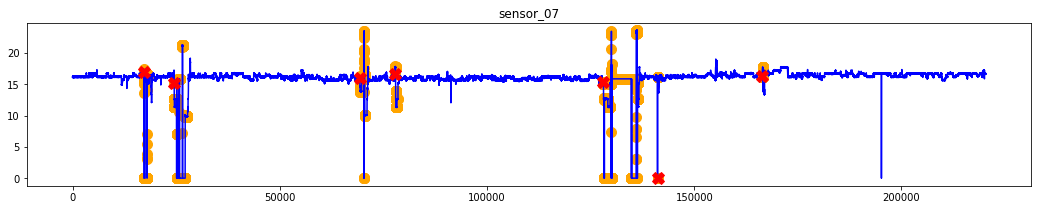

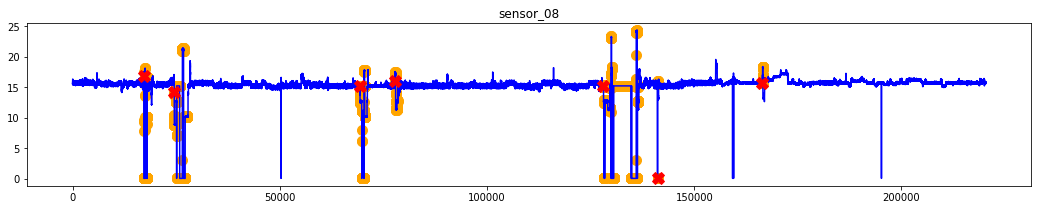

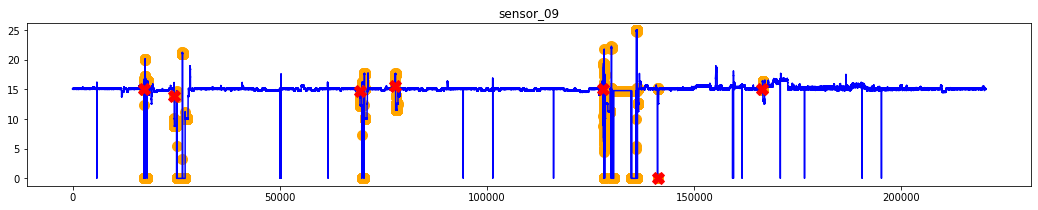

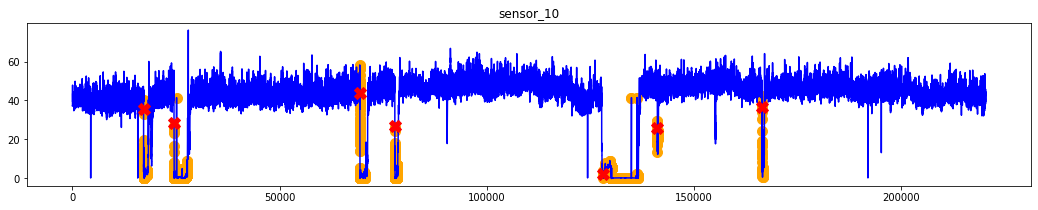

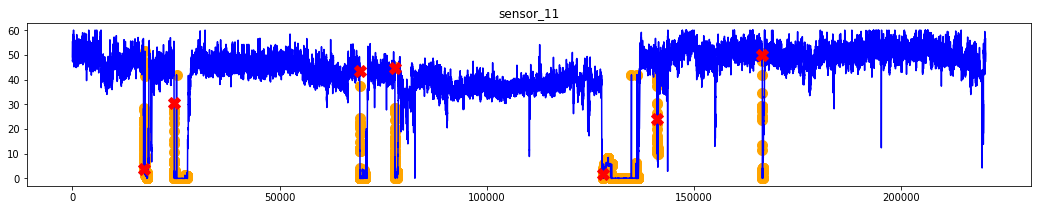

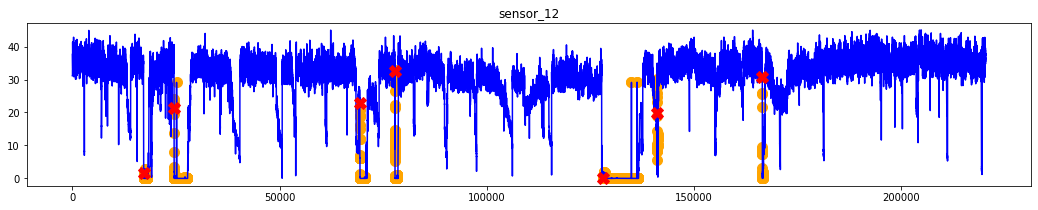

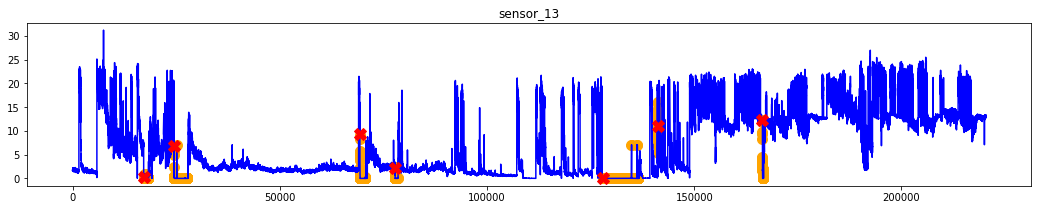

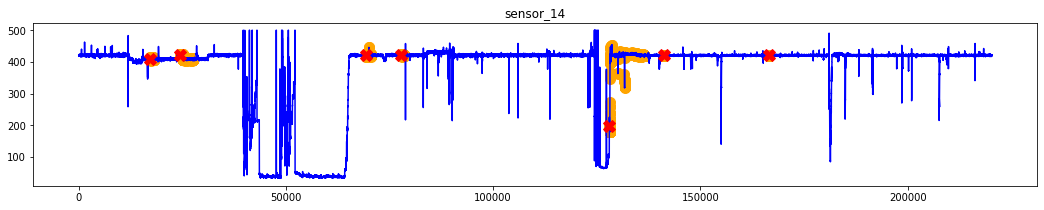

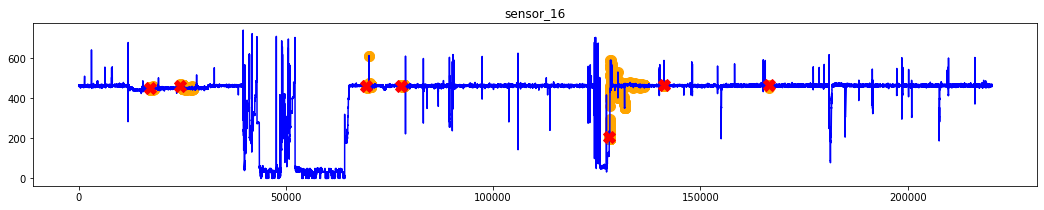

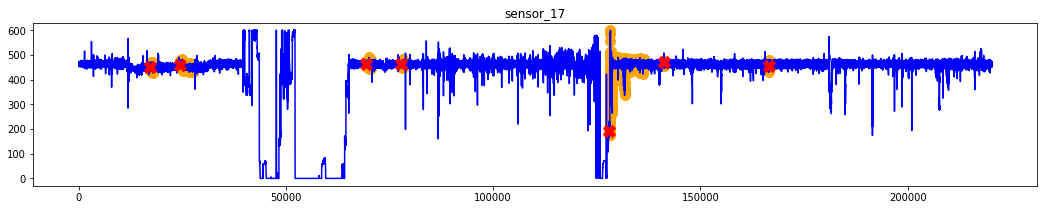

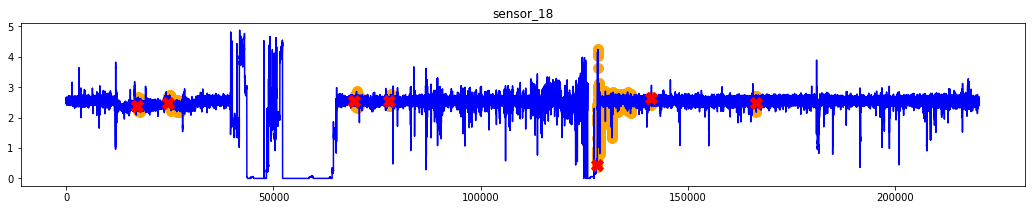

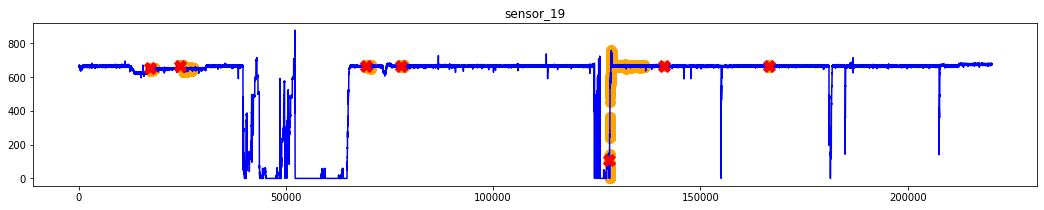

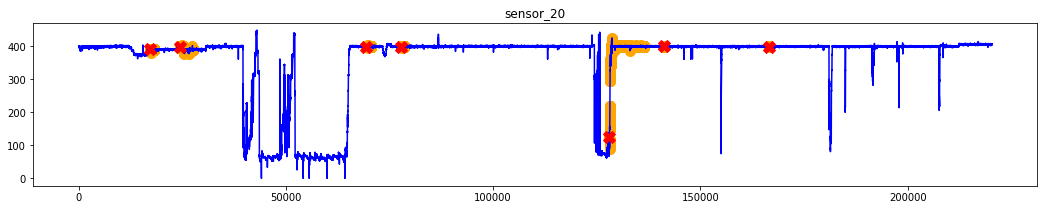

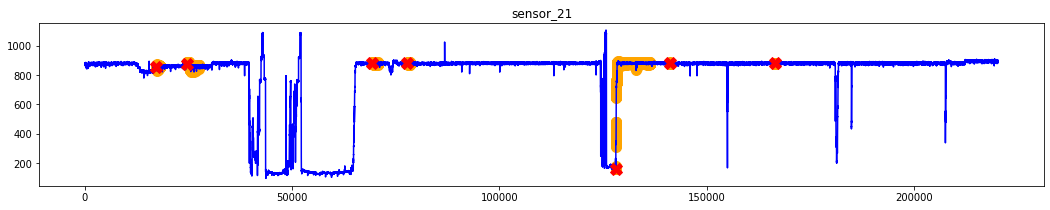

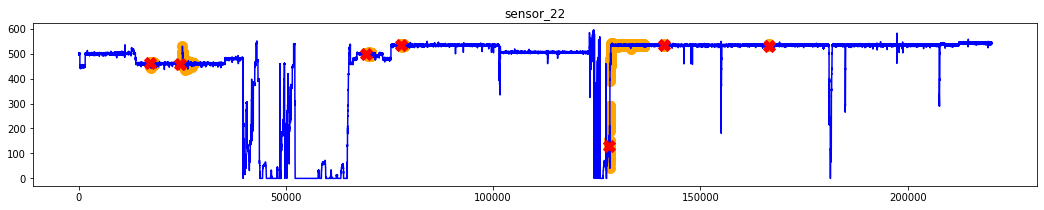

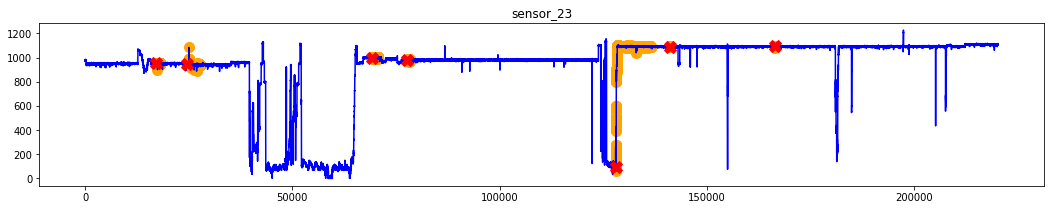

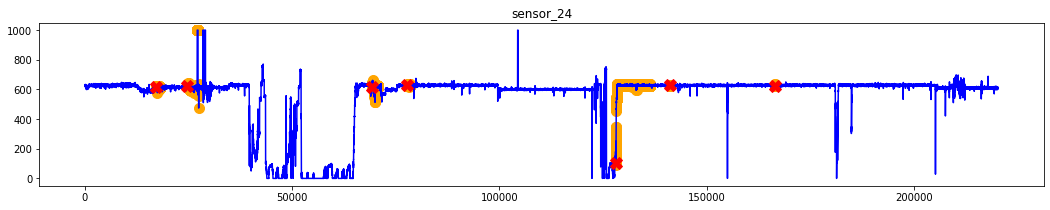

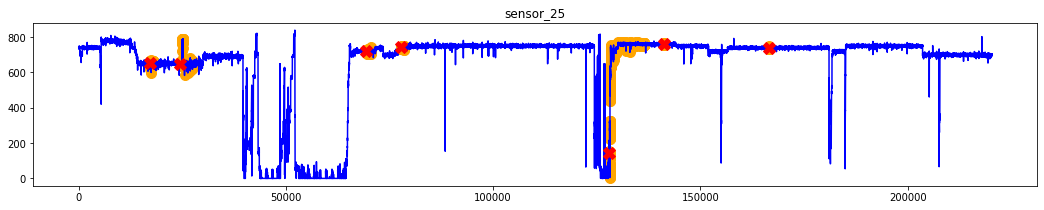

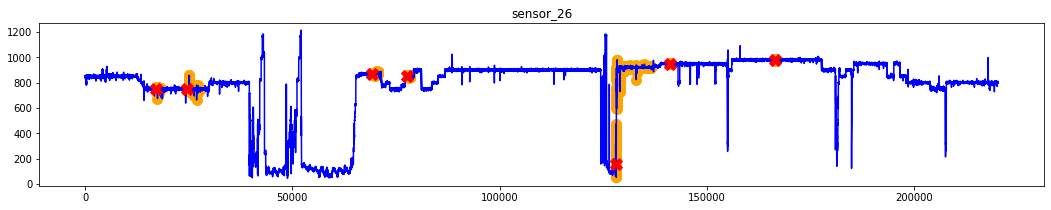

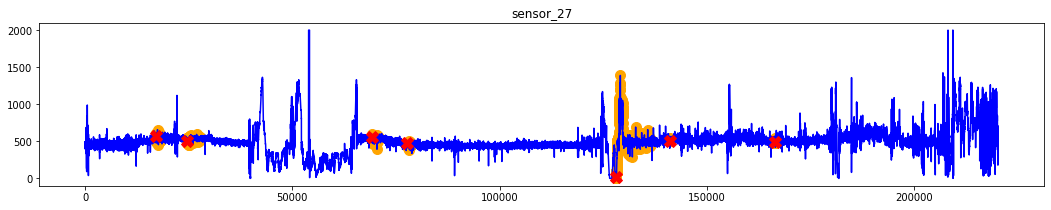

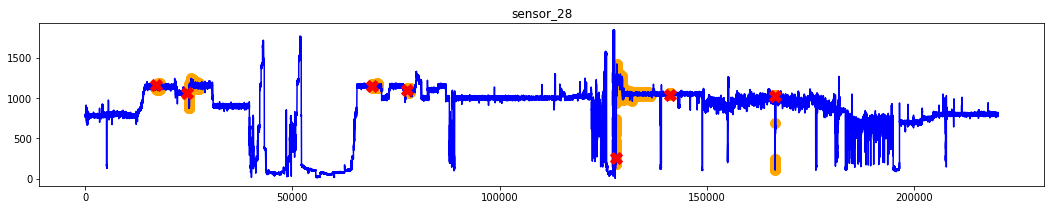

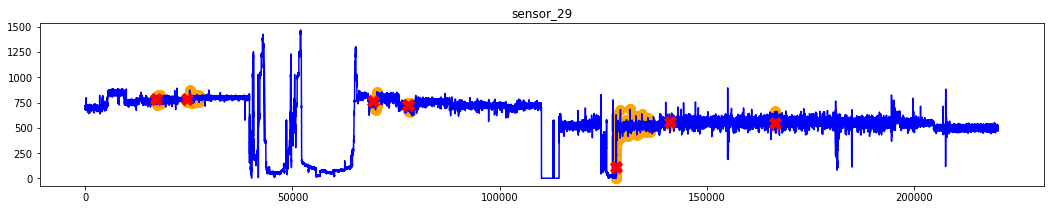

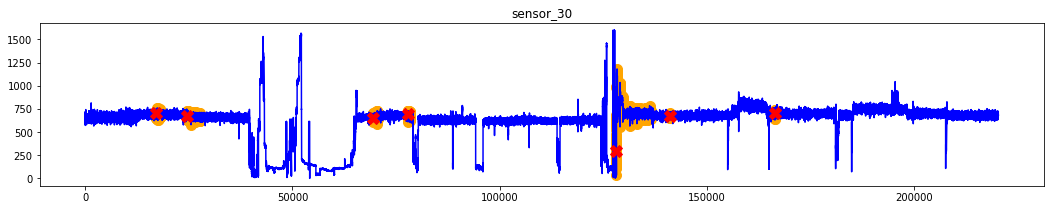

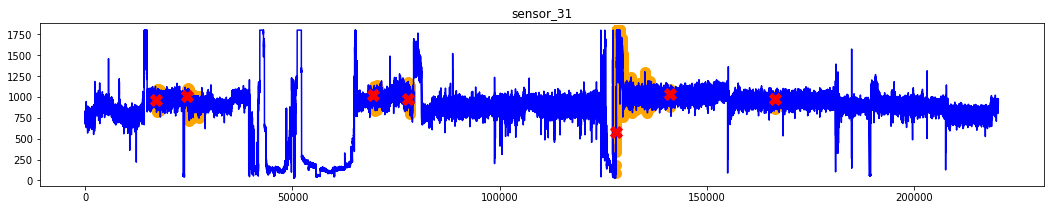

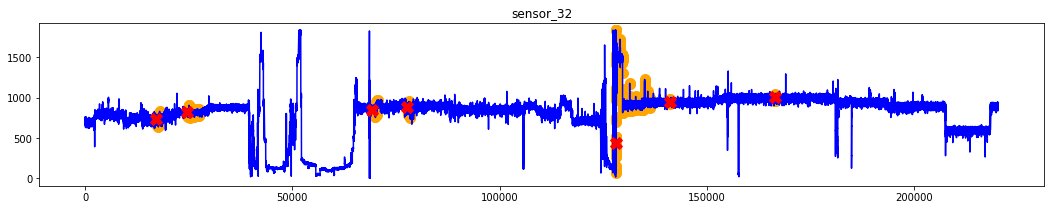

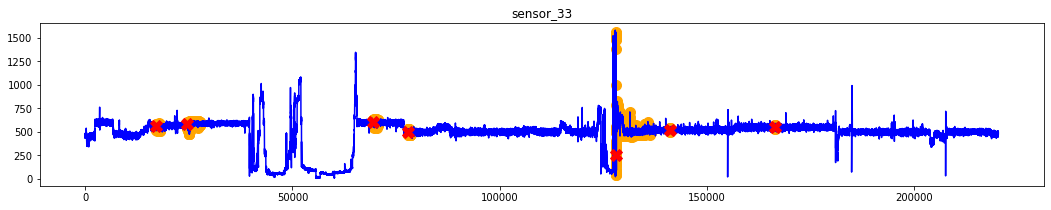

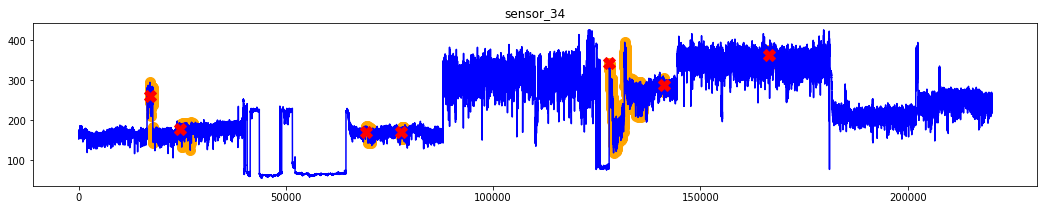

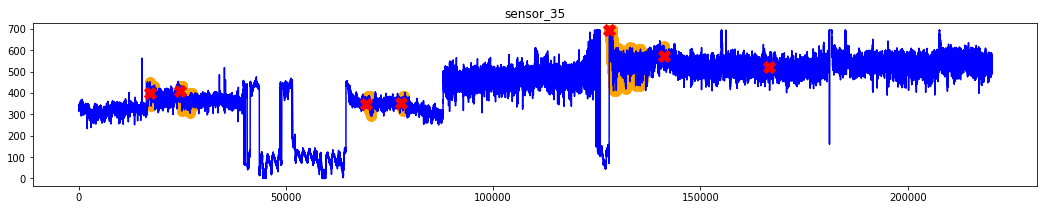

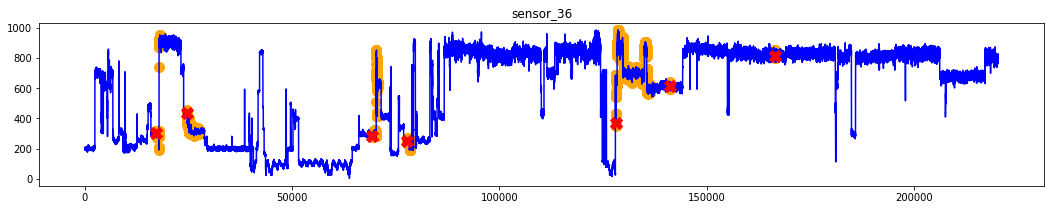

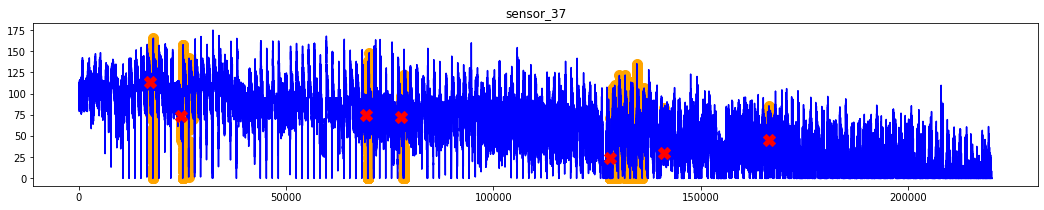

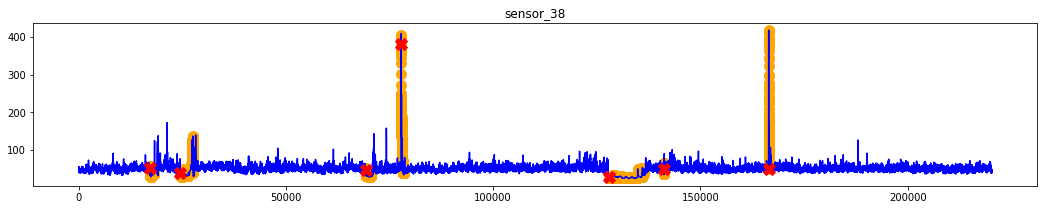

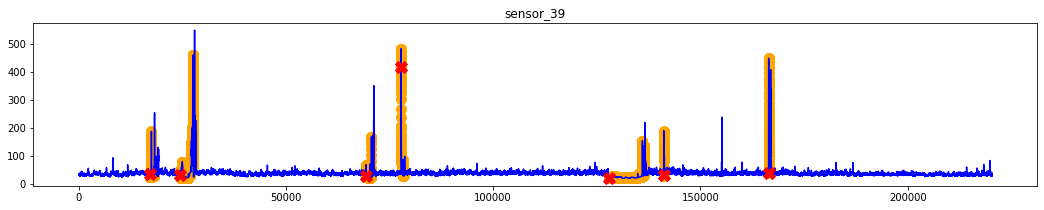

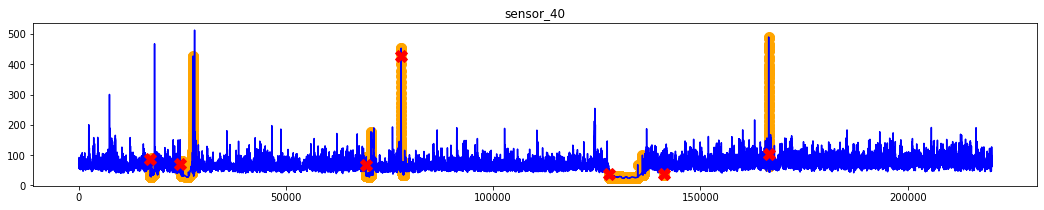

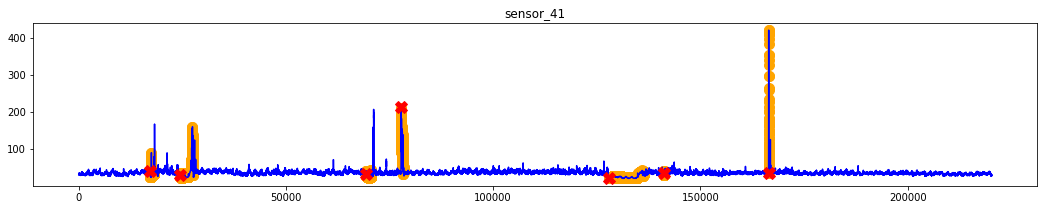

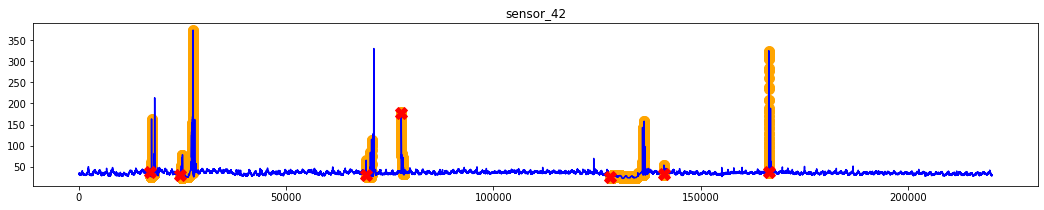

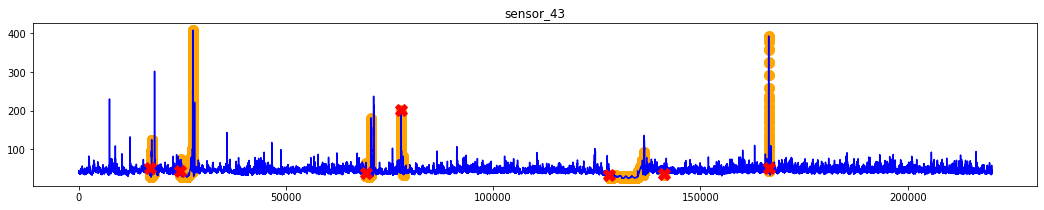

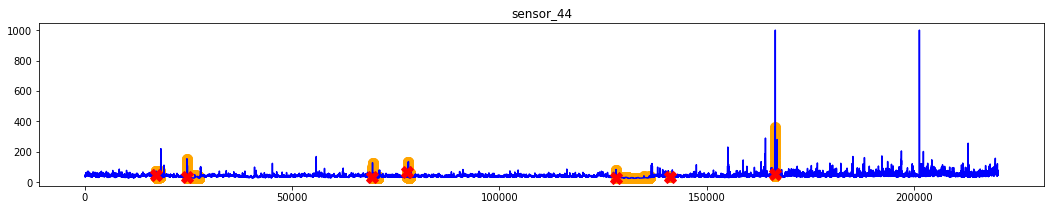

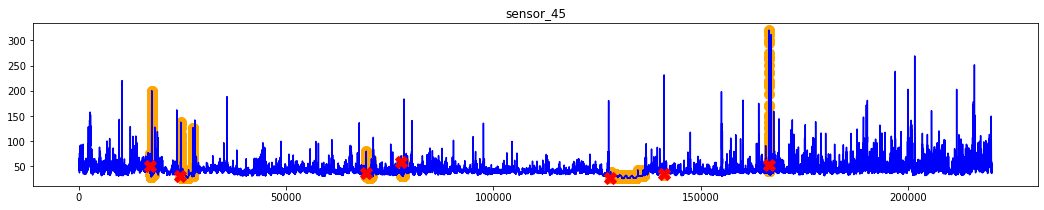

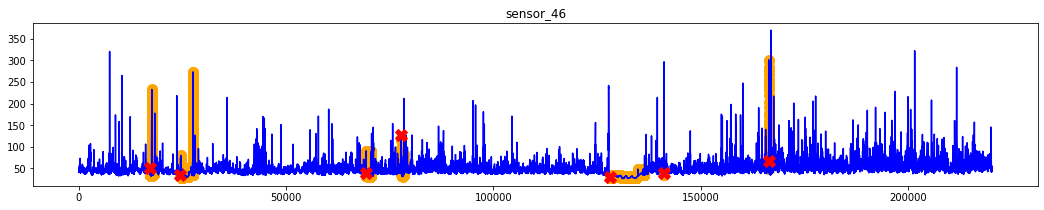

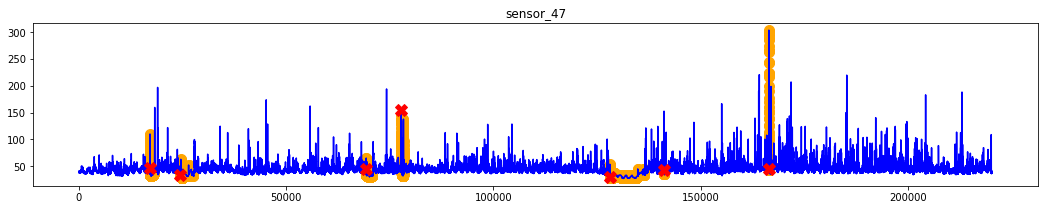

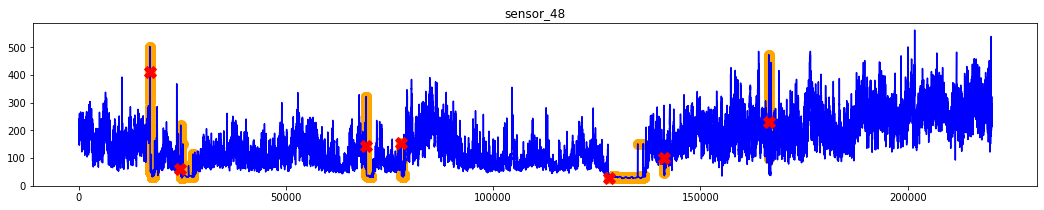

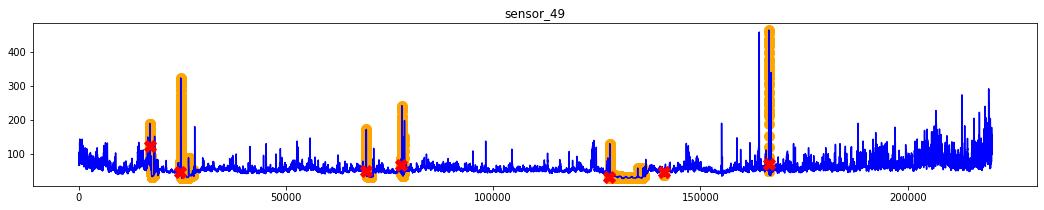

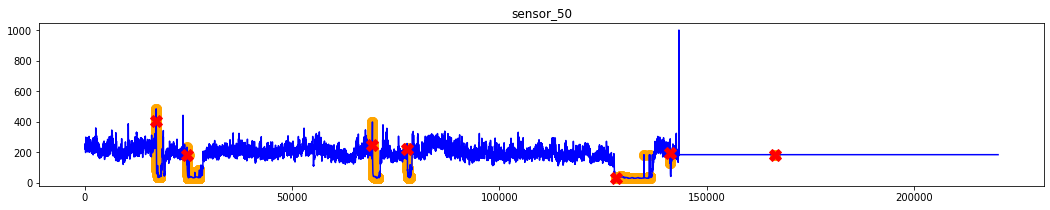

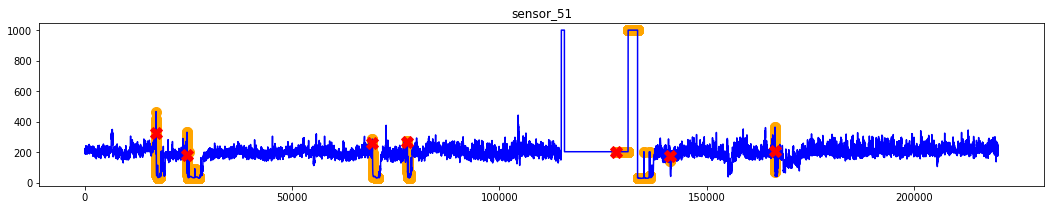

In [9]:
# Visualize sensor data where the pump was broken
broken = df_data[df_data['machine_status']=='BROKEN']
recovering = df_data[df_data['machine_status']=='RECOVERING']

# Extract the names of the numerical columns
names = sorted(list(set(df_data.columns)-set(['machine_status'])))

# Plot time series for each sensor with BROKEN state marked with X in red color and RECOVERING state 
# marked with orange color
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(recovering[name], linestyle='none', marker='o', color='orange', markersize=10)
    _ = plt.plot(df_data[name], color='blue')
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.title(name)
    plt.show()

## Stationarity and Autocorrelation
In time series analysis, it is important that the data is stationary and have no autocorrelation. 

**Stationarity** refers to the behavior where the mean and standard deviation of the data changes over time, the data with such behavior is considered not stationary. 

On the other hand, **autocorrelation** refers to the behavior of the data where the data is correlated with itself in a different time period.

**In essence, the data must be stationary and not autocorrelated.**

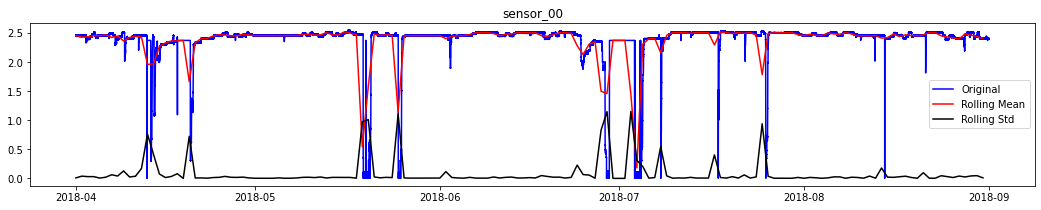

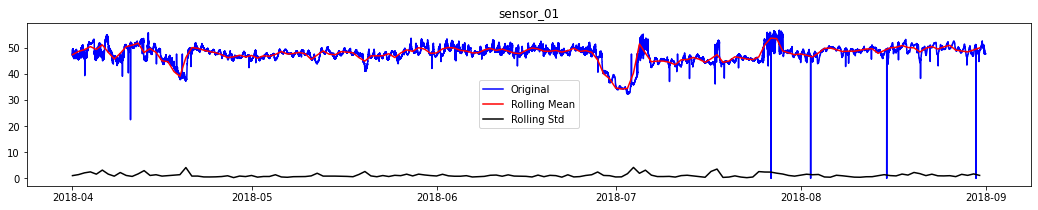

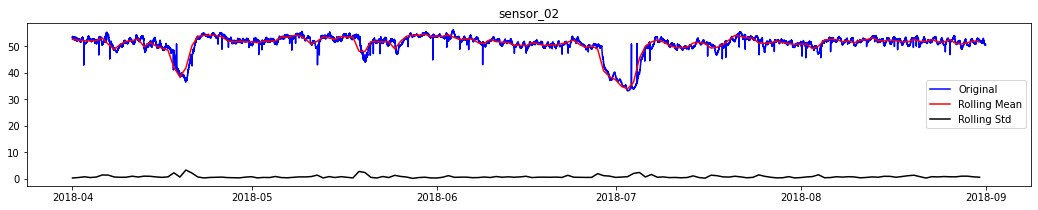

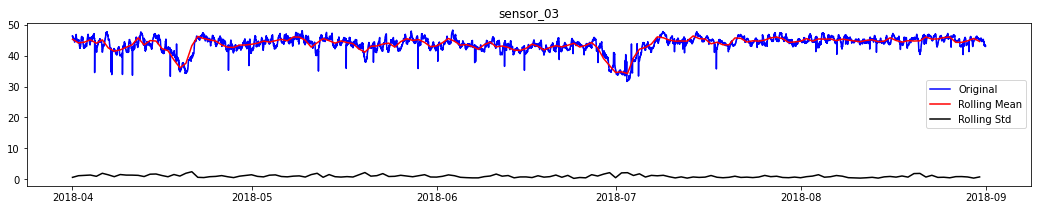

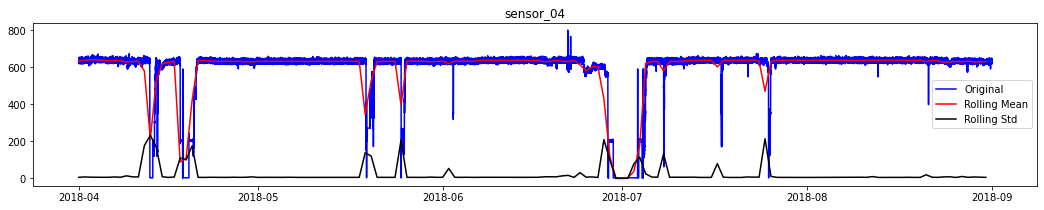

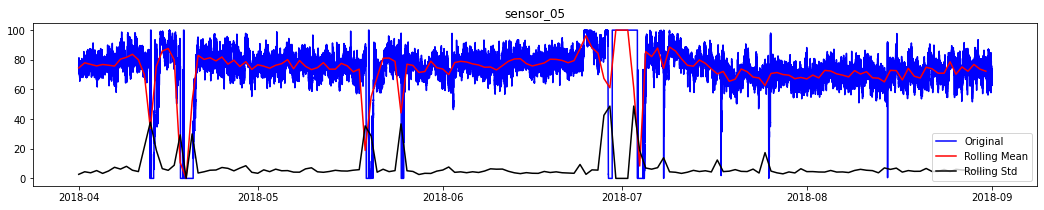

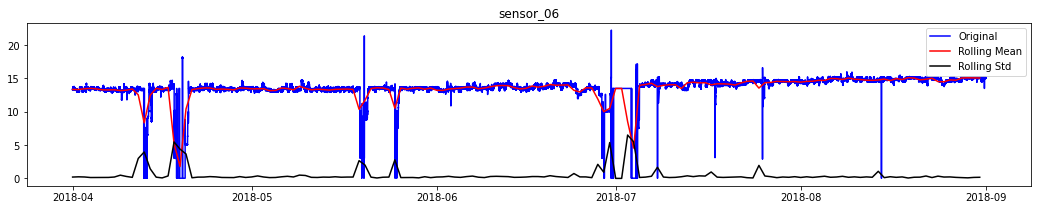

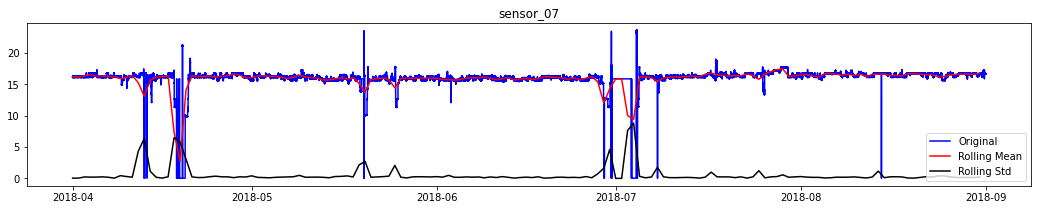

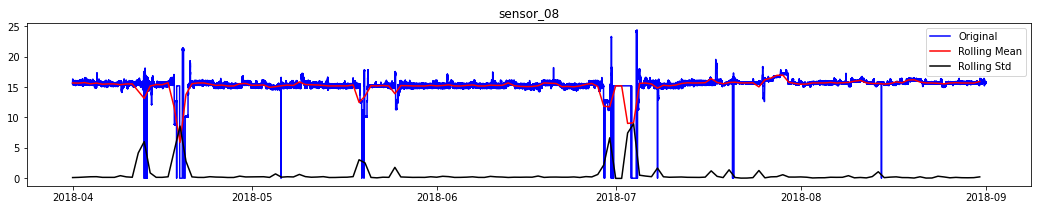

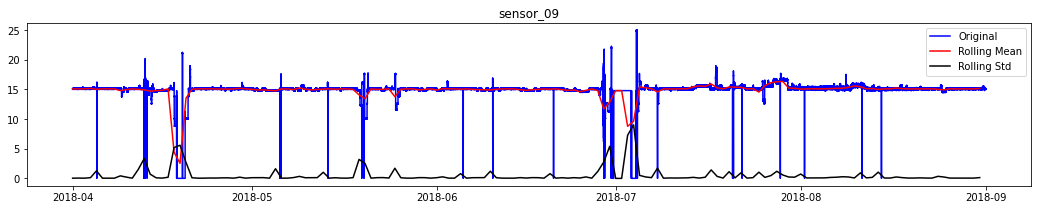

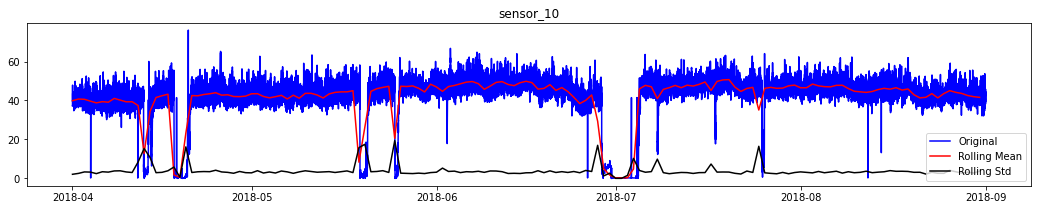

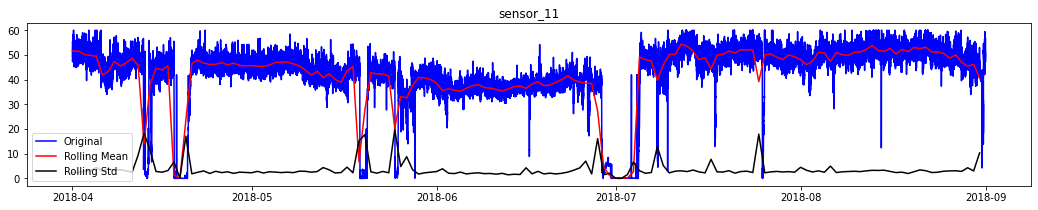

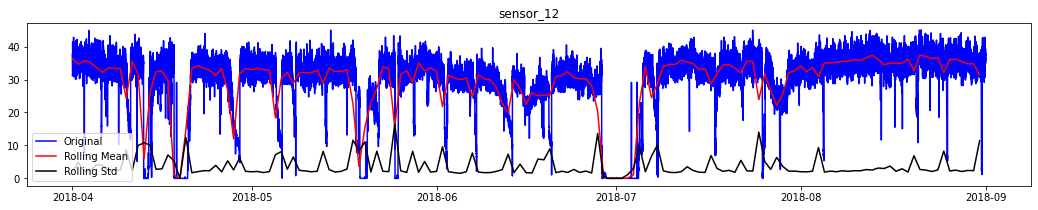

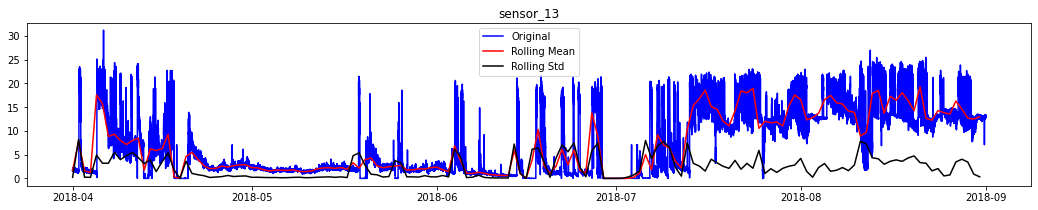

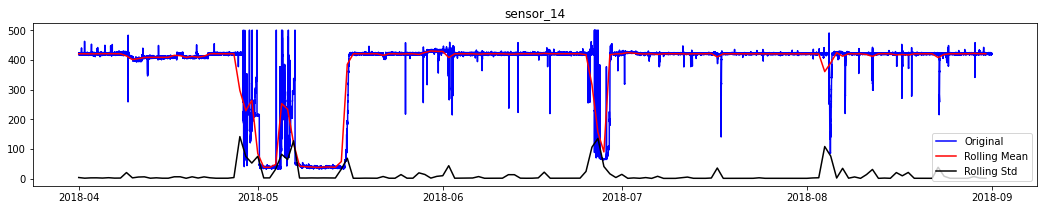

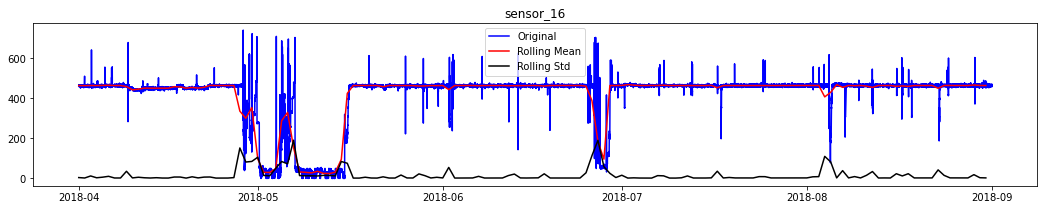

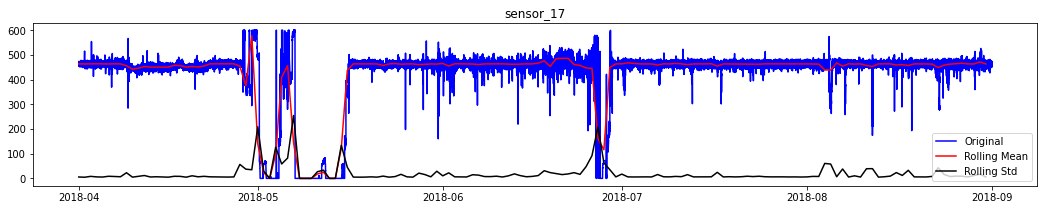

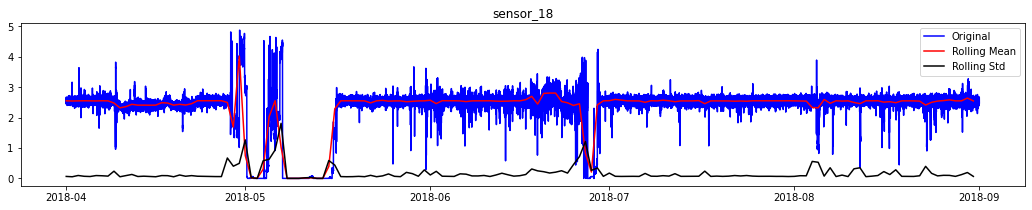

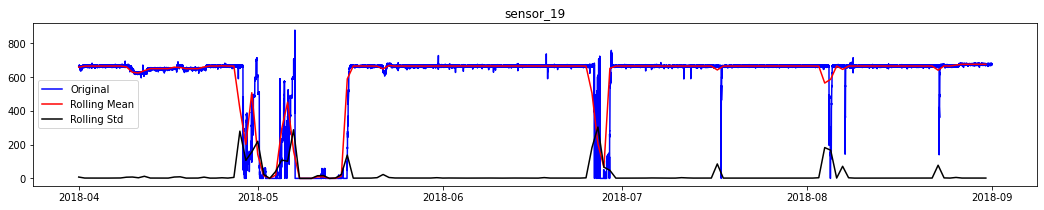

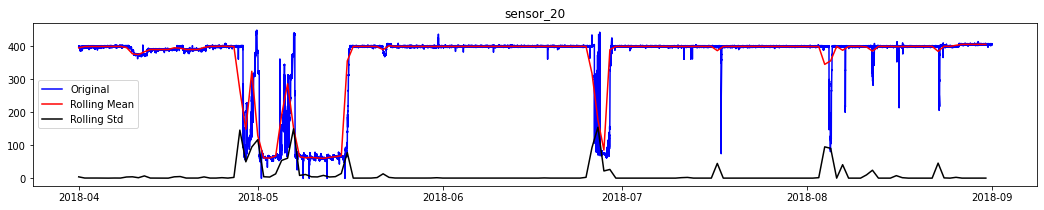

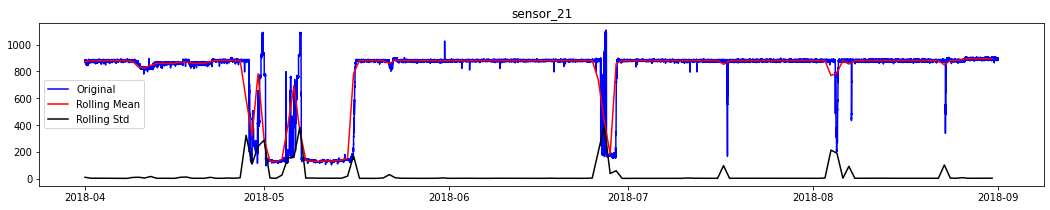

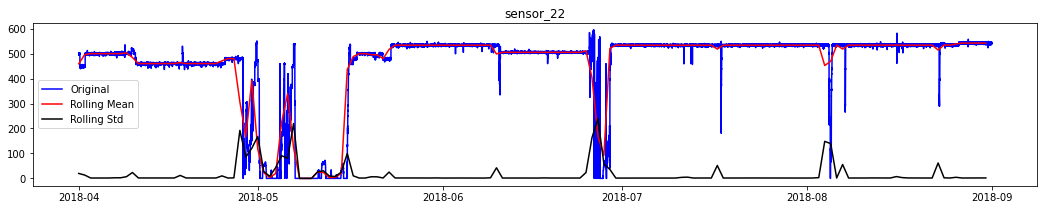

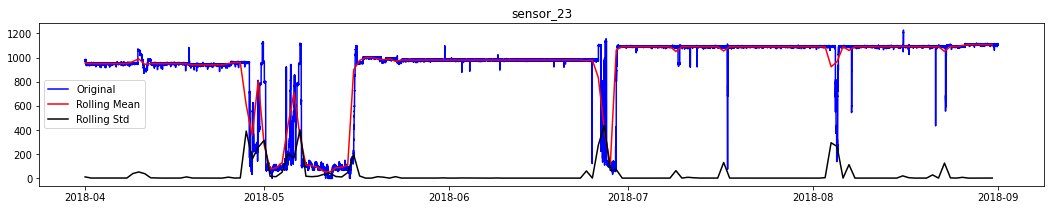

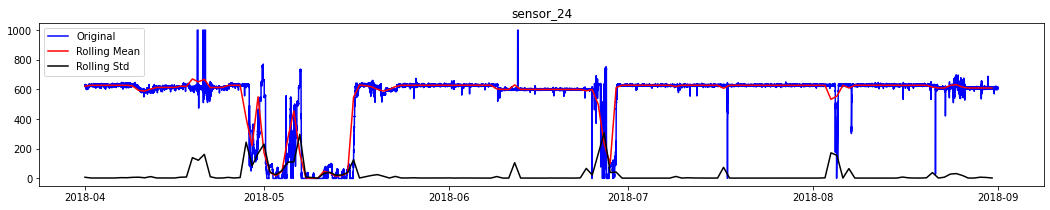

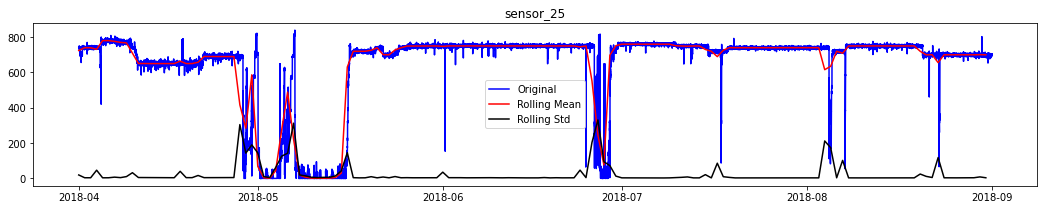

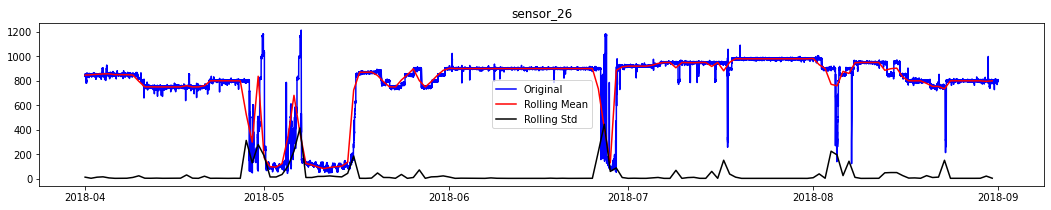

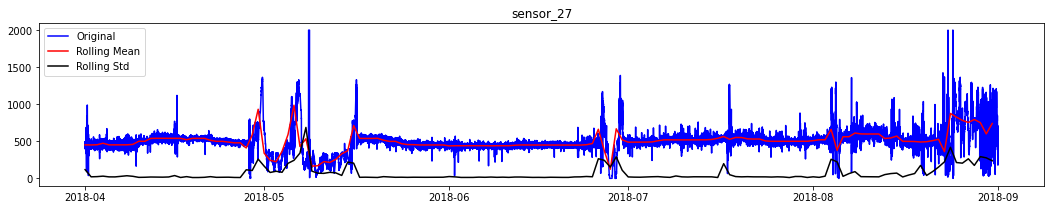

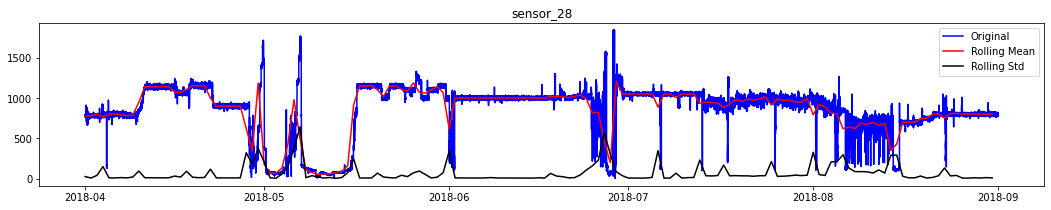

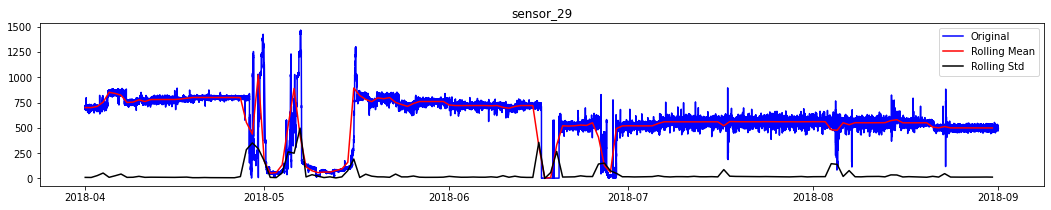

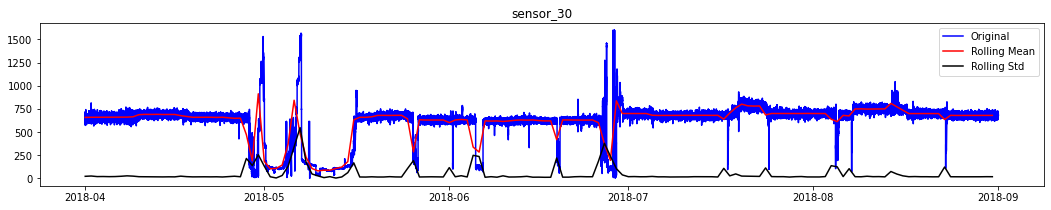

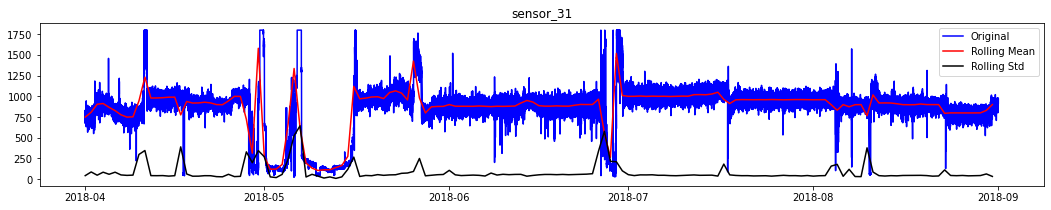

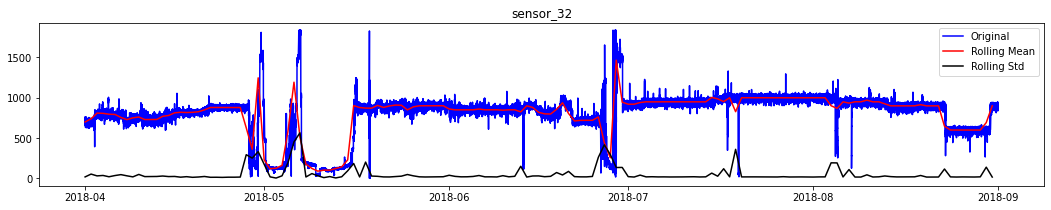

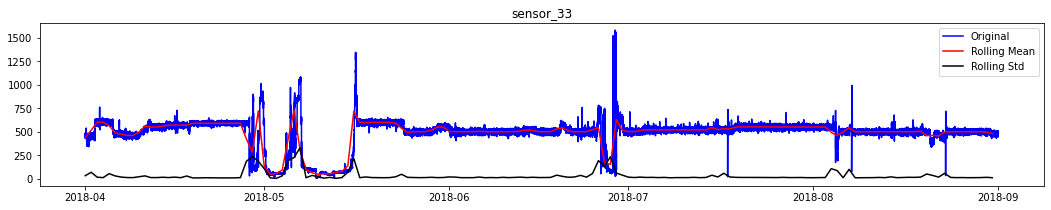

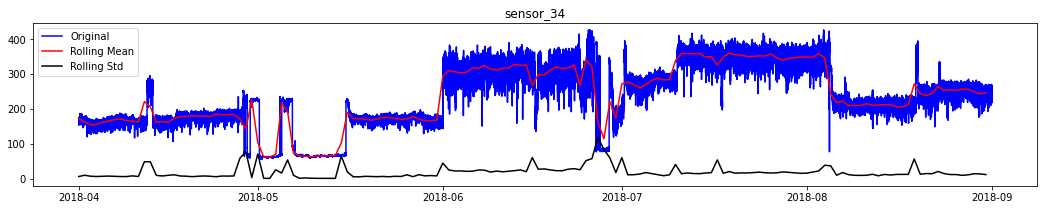

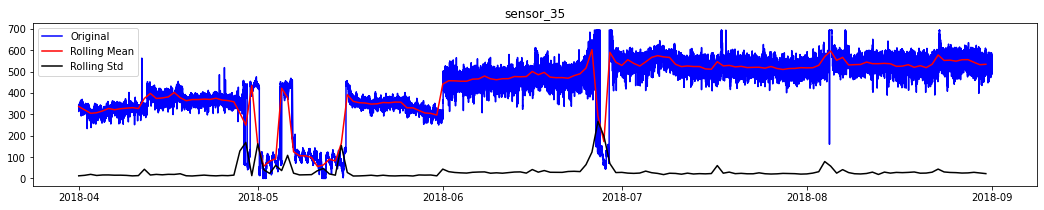

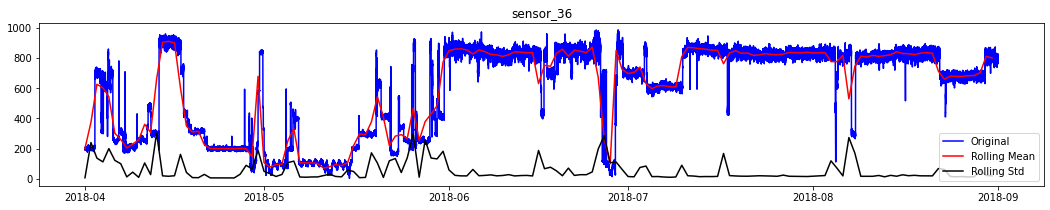

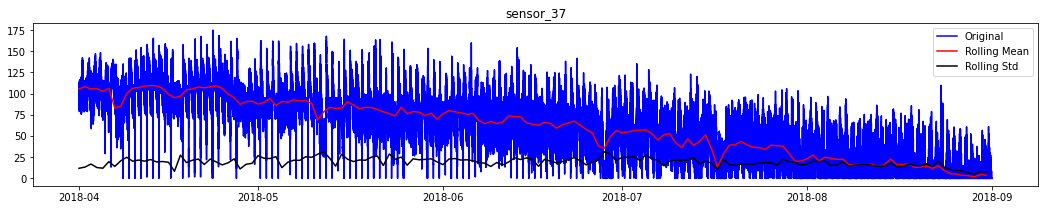

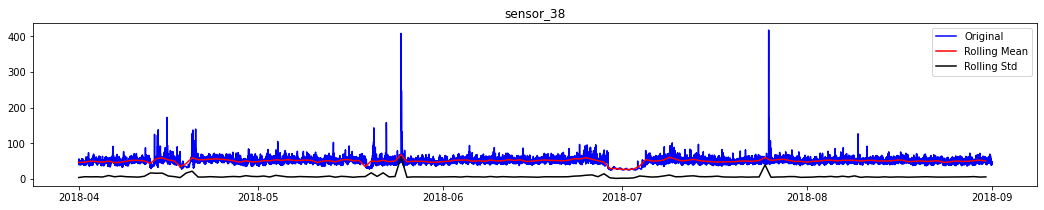

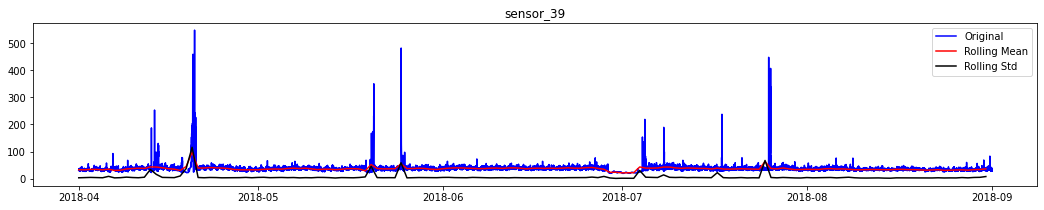

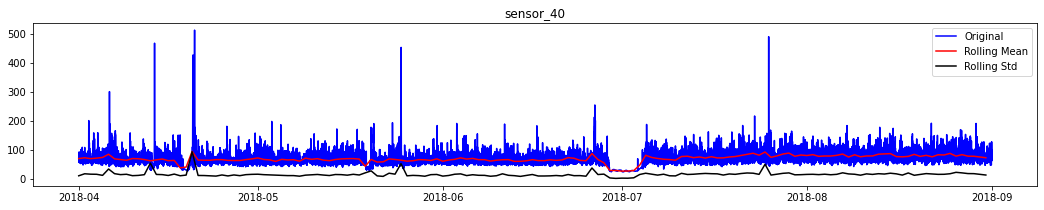

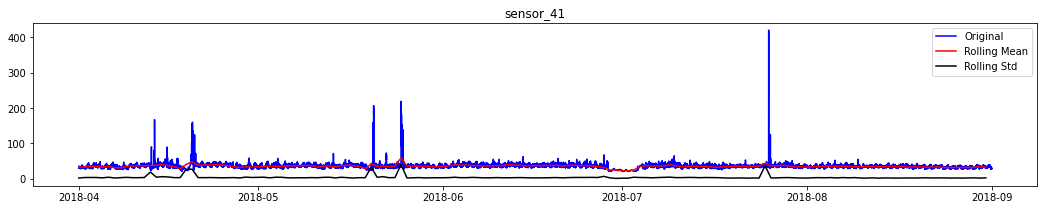

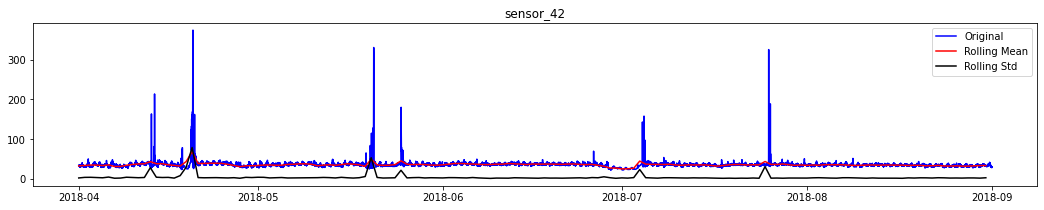

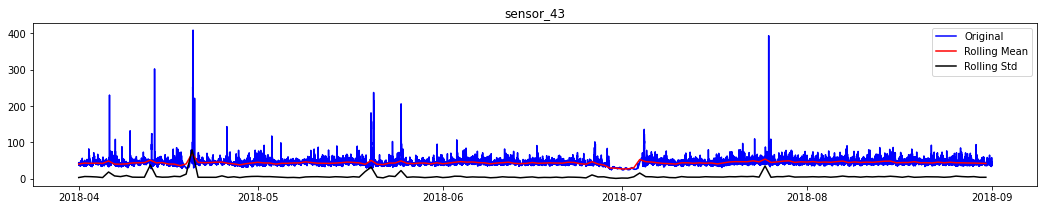

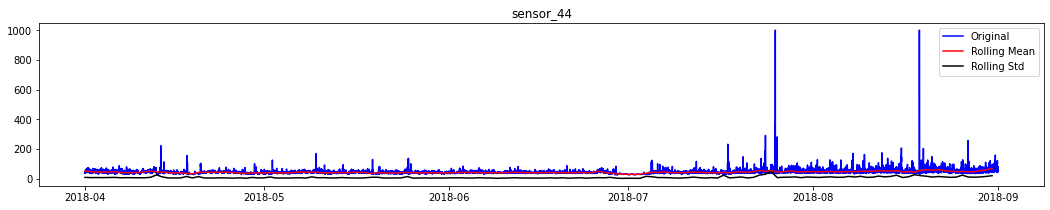

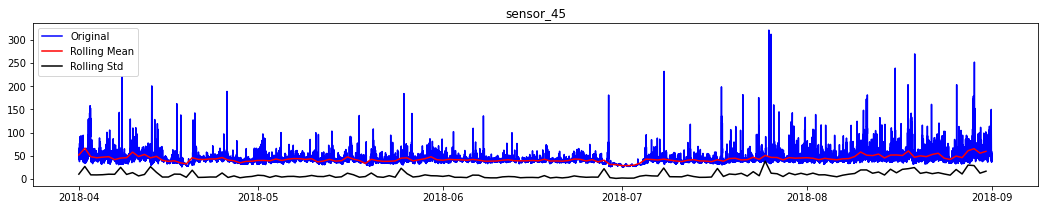

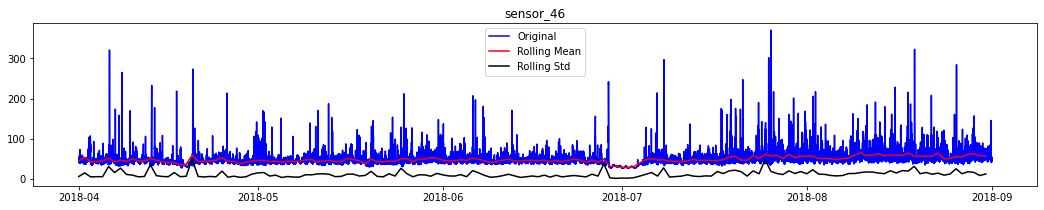

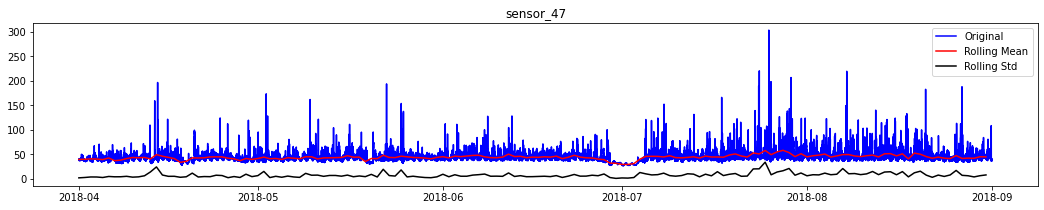

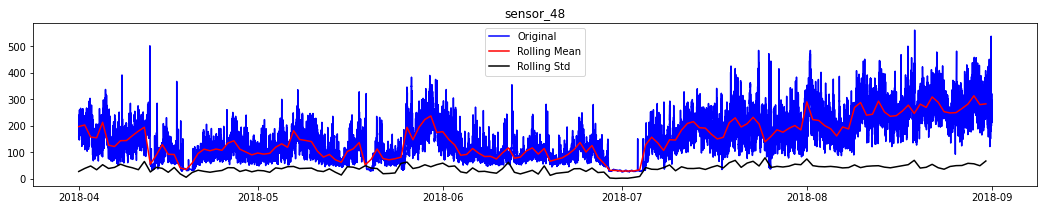

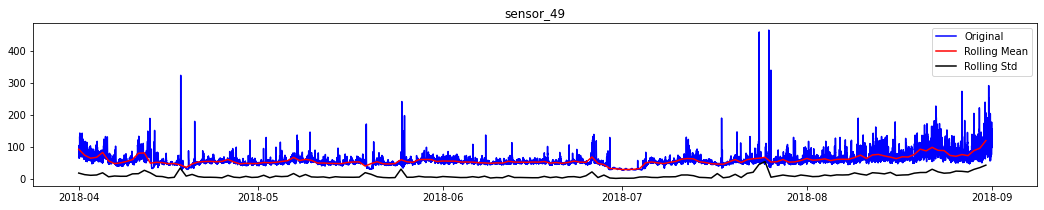

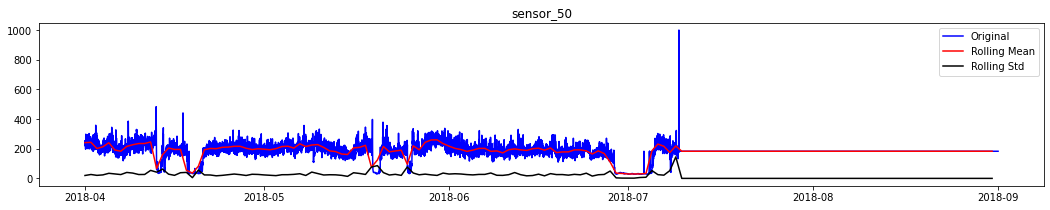

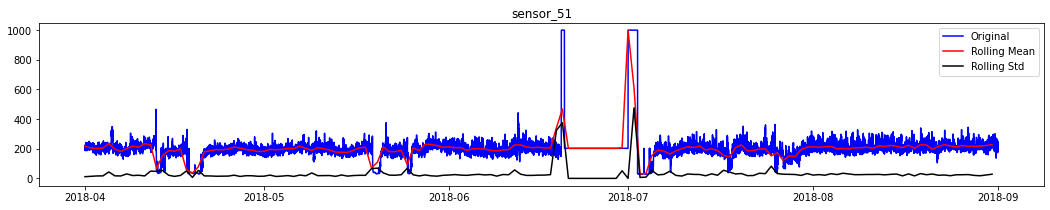

In [10]:
df_data_timed = df_data.set_index('date')

# Resample the entire dataset by daily average
rollmean = df_data_timed.resample(rule='D').mean()  # Rolling mean
rollstd = df_data_timed.resample(rule='D').std()    # Rolling std

# Plot time series for each sensor with its mean and standard deviation
names = sorted(list(set(df_data_timed.columns)-set(['machine_status'])))
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df_data_timed[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

Looking at the readings from one of the sensors, for example 'sensor_17' in this case, notice that the data actually looks pretty stationary where the rolling mean and standard deviation don’t seem to change over time except during the downtime of the pump which is expected. This was the case for most of the sensors in this data set but it may not always be the case in which situations various transformation methods must be applied to make the data stationary before training the data.

# Pre-Processing and Dimensionality Reduction

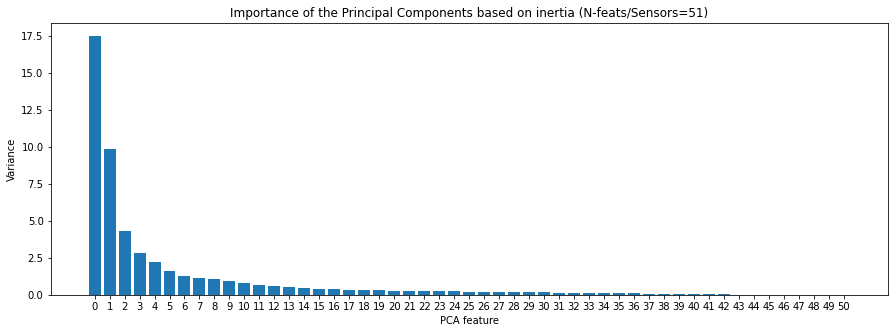

In [11]:
# Perform PCA and look at the most important principal components based on inertia
names = sorted(list(set(df_data.columns)-set(['date', 'machine_status'])))

# Get data
x = df_data[names]
n_feats = x.shape[1]

# Create processing pipeline
scaler = StandardScaler()
pca = PCA(n_components=n_feats)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)


# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"Importance of the Principal Components based on inertia (N-feats/Sensors={n_feats})")
plt.show()

It appears that the first two principal components are the most important as per the features extracted by the PCA in above importance plot. So as the next step, I will perform PCA with 2 components which will be my features to be used in the training of the models.

In [12]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
feats_pca = pca.fit_transform(x)

df_pca = pd.DataFrame(data = feats_pca, columns = ['pc1', 'pc2'])

df_pca

pc1         pc2
0        69.942182  265.865297
1        69.942182  265.865297
2        28.250111  283.621565
3        24.950602  290.367435
4        30.041143  294.778305
...            ...         ...
220315 -308.523554 -274.586942
220316 -294.595456 -256.315737
220317 -300.199727 -256.921670
220318 -285.133341 -263.087081
220319 -298.173703 -264.531555

[220320 rows x 2 columns]

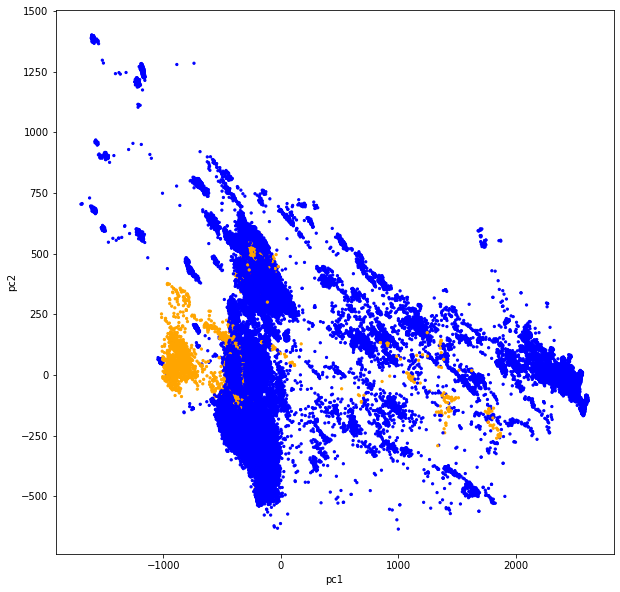

In [13]:
MAP_MACHINE_STATUS_COLORS = {
    'NORMAL': 'blue',
    'BROKEN': 'red',
    'RECOVERING': 'orange'
}

plt.figure(figsize=(10, 10))
_colors = [MAP_MACHINE_STATUS_COLORS[status] for status in df_data['machine_status']]
plt.scatter(x=df_pca['pc1'], y=df_pca['pc2'], color=_colors, s=5)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

## Check for Stationary and No Autocorrelation
Check again the stationarity and autocorrelation of these two principal components just to be sure they are stationary and not autocorrelated.

### Stationary

In [14]:
from statsmodels.tsa.stattools import adfuller


def checkStationaryUsingDickeyFullerTest(data, thres_stnry=0.05):
    """
    Check if the data is stationary using Dickey Fuller Test.
    Ref:
        https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
        https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results
    """
    # Run Augmented Dickey Fuller Test
    
    # Returns tuple of (adf, pvalue, usedlag, nobs, critical_values_dict, icbest)
    result = result = adfuller(data)
    
    # Get probability that null hypothesis will not be rejected
    pvalue = result[1]
    
    # If pvalue is less than 0.05 (5%) then the Null Hypothesis can be rejected
    # and we cann say the data is stationary
    is_stnry = pvalue < thres_stnry
    
    return is_stnry, result



THRES_STNRY = 0.05

is_stationary, result = checkStationaryUsingDickeyFullerTest(df_pca['pc1'], thres_stnry=THRES_STNRY)
print(f"Is stationary col 'pc1': {is_stationary} (pvalue={result[1]})")

is_stationary, result = checkStationaryUsingDickeyFullerTest(df_pca['pc2'], thres_stnry=THRES_STNRY)
print(f"Is stationary col 'pc2': {is_stationary} (pvalue={result[1]})")

Is stationary col 'pc1': True (pvalue=2.466725883425879e-05)
Is stationary col 'pc2': True (pvalue=1.7778434903063307e-06)


### Autocorelation
It can be done one of the two ways; either with the pandas autocorr() method or ACF plot.

**Degree of correlation:**
Ref: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/

- **Perfect**: If the value is near ± 1, then it said to be a perfect correlation: as one variable increases, the other variable tends to also increase (if positive) or decrease (if negative).
- **High degree**: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.
- **Moderate degree**: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation.
- **Low degree**: When the value lies below + .29, then it is said to be a small correlation.
- **No correlation**: When the value is zero.

pc1: Autocorrelation:  0.9929106271030583
pc2: Autocorrelation:  0.9843598573772935


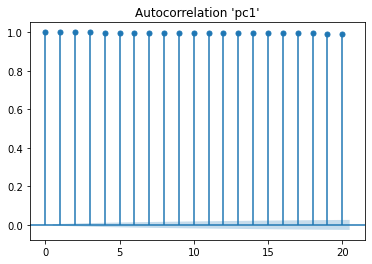

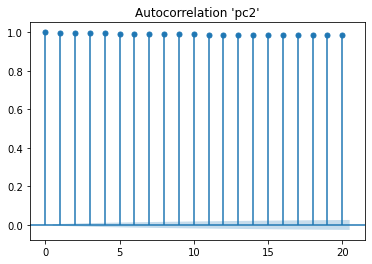

In [15]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf

LAGS = 20
ALPHA = 0.05

print("pc1: Autocorrelation: ", df_pca['pc1'].dropna().autocorr(lag=LAGS) )
_ = plot_acf(df_pca['pc1'].dropna(), lags=LAGS, alpha=ALPHA, title="Autocorrelation 'pc1'")

print("pc2: Autocorrelation: ", df_pca['pc2'].dropna().autocorr(lag=LAGS) )
_ = plot_acf(df_pca['pc2'].dropna(), lags=LAGS, alpha=ALPHA, title="Autocorrelation 'pc2'")

# Modeling

## A. Interquartile Range
1. Calculate IQR which is the difference between 75th (Q3)and 25th (Q1) percentiles.
2. Calculate upper and lower bounds for the outlier.
3. Filter the data points that fall outside the upper and lower bounds and flag them as outliers.
4. Finally, plot the outliers on top of the time series data (the readings from sensor_11 in this case)

/home/gagan/PythonEnv/env_deeplearning/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='pc2'>

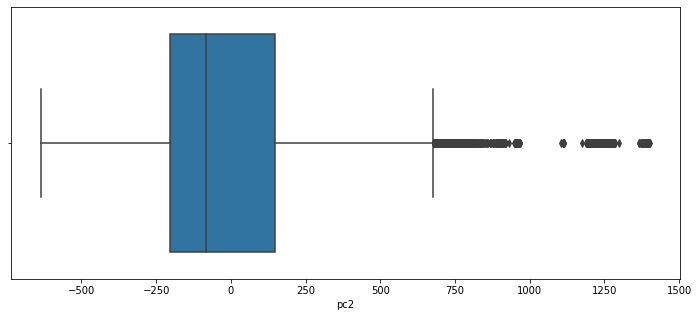

In [16]:
plt.figure(figsize=(12,5))
sns.boxplot(df_pca['pc2'])

In [17]:
def getQuartileLowerUpperBound(pd_series):
    q1, q3 = pd_series.quantile([0.25, 0.75])
    iqr = q3-q1
    
    # Calculate upper and lower bounds for outlier for pc1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    
    return lower, upper


/home/gagan/PythonEnv/env_deeplearning/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


-740.9808649888967 222.78396607088996


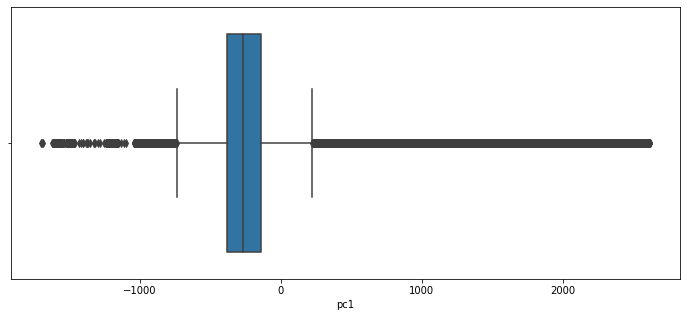

In [18]:
plt.figure(figsize=(12,5))
sns.boxplot(df_pca['pc1'])

lower_pc1, upper_pc1 = getQuartileLowerUpperBound(df_pca['pc1'])
print(lower_pc1, upper_pc1)

df_data['anomaly_pc1'] = ((df_pca['pc1']>upper_pc1) | (df_pca['pc1']<lower_pc1)).astype('int')

/home/gagan/PythonEnv/env_deeplearning/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


-734.0274078924904 677.8571684226748


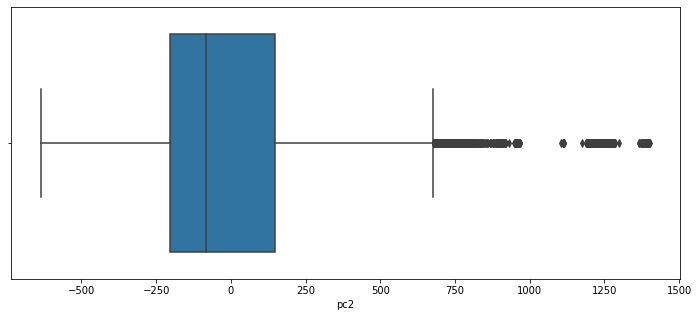

In [19]:
plt.figure(figsize=(12,5))
sns.boxplot(df_pca['pc2'])

lower_pc2, upper_pc2 = getQuartileLowerUpperBound(df_pca['pc2'])
print(lower_pc2, upper_pc2)

df_data['anomaly_pc2'] = ((df_pca['pc2']>upper_pc2) | (df_pca['pc2']<lower_pc2)).astype('int')

In [20]:
# SENSOR_LABEL = 'sensor_01'
# SENSOR_LABEL = 'sensor_02'
SENSOR_LABEL = 'sensor_11'

<Figure size 1296x216 with 0 Axes>

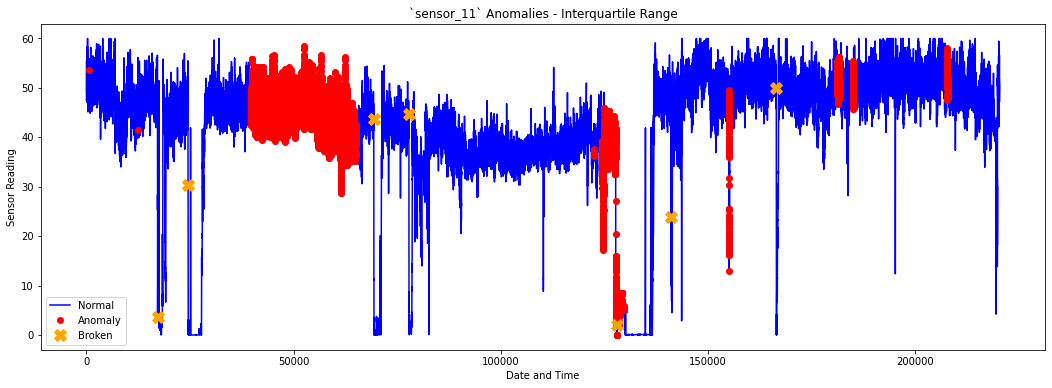

In [21]:
# Plot the outliers from pc1 on top of the sensor and see where they occured in the time series


# Get anomolies
a = df_data[df_data['anomaly_pc1'] == 1]

# Plot
plt.figure(figsize=(18,3))
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df_data[SENSOR_LABEL], color='blue', label='Normal')
_ = plt.plot(a[SENSOR_LABEL], linestyle='none', marker='o', color='red', markersize=6, label='Anomaly')
_ = plt.plot(broken[SENSOR_LABEL], linestyle='none', marker='X', color='orange', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'`{SENSOR_LABEL}` Anomalies - Interquartile Range')
_ = plt.legend(loc='best')
plt.show()

The anomalies are detected right before the pump breaks down!

## B. K-Means
1. Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
2. We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.13 (13% of df are outliers as depicted).
3. Calculate number_of_outliers using outliers_fraction.
4. Set threshold as the minimum distance of these outliers.
5. The anomaly result of anomaly1 contains the above method Cluster (0:normal, 1:anomaly).
6. Visualize anomalies with Time Series view.

Distance Threshold: 2766.4624480718016


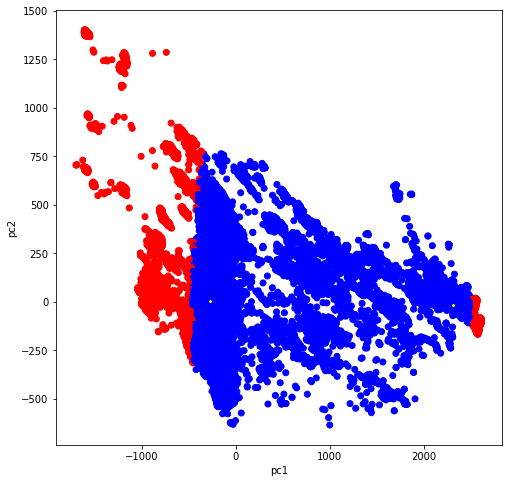

In [22]:
# Import necessary libraries
from sklearn.cluster import KMeans


# Stating k-means clustering with k=2 as we already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_pca.values)
labels = kmeans.predict(df_pca.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
centroids = kmeans.cluster_centers_


# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """
    Function that calculates the distance between a point and centroid of a cluster, 
    returns the distances in pandas series
    """
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)


# Assume that 13% of the entire data set are anomalies 
OUTLIERS_FACTION = 0.13


# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(df_pca, kmeans)

# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(OUTLIERS_FACTION*len(distance))


# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
print(f"Distance Threshold: {threshold}")


# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_data['anomaly_kmeans'] = (distance >= threshold).astype(int)


# Plot kmeans scatter
plt.figure(figsize=(8,8))
_colors = [('red' if is_anomaly else 'blue') for is_anomaly in df_data['anomaly_kmeans'].to_list()]
plt.scatter(x=df_pca['pc1'], y=df_pca['pc2'], color=_colors)
plt.scatter(centroids[:,0] , centroids[:,1] , s=5, marker='*', color = 'yellow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

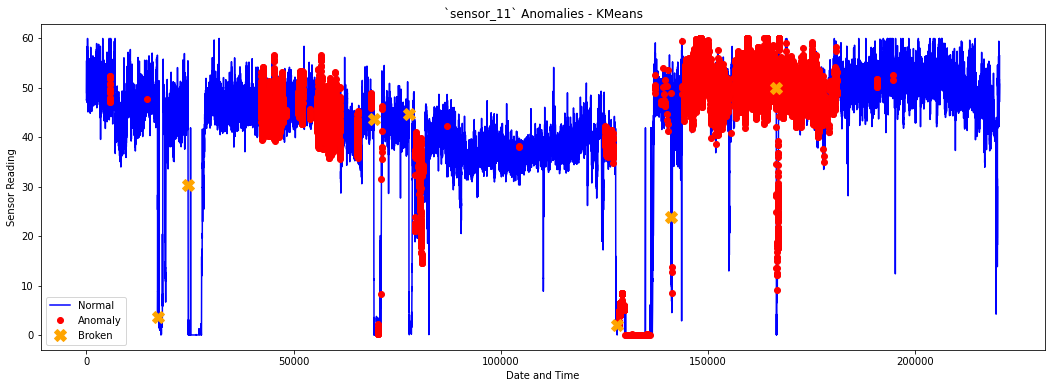

In [23]:
# Get anomalies & Plot
a = df_data.loc[df_data['anomaly_kmeans'] == 1]

_ = plt.figure(figsize=(18,6))
_ = plt.plot(df_data[SENSOR_LABEL], color='blue', label='Normal')
_ = plt.plot(a[SENSOR_LABEL], linestyle='none', marker='o', color='red', markersize=6, label='Anomaly')
_ = plt.plot(broken[SENSOR_LABEL], linestyle='none', marker='X', color='orange', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'`{SENSOR_LABEL}` Anomalies - KMeans')
_ = plt.legend(loc='best')
plt.show()

## C. Isolation Forest

In [24]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest


# Assume that 13% of the entire data set are anomalies
OUTLIERS_FACTION = 0.13

# Train Model
model =  IsolationForest(contamination=OUTLIERS_FACTION)
model.fit(df_pca.values) 


# Predict
df_data['anomaly_isoFrst'] = pd.Series( model.predict(df_pca.values) )

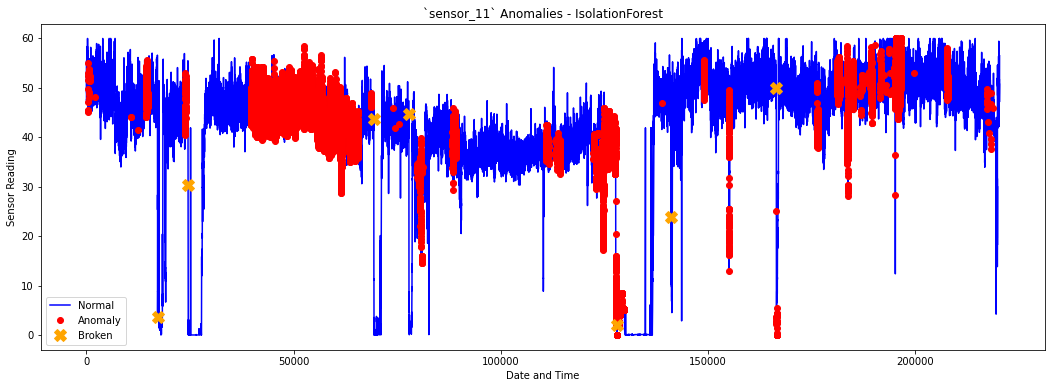

In [25]:
# Get anomalies & Plot
a = df_data.loc[df_data['anomaly_isoFrst'] == -1]

_ = plt.figure(figsize=(18,6))
_ = plt.plot(df_data[SENSOR_LABEL], color='blue', label='Normal')
_ = plt.plot(a[SENSOR_LABEL], linestyle='none', marker='o', color='red', markersize=6, label='Anomaly')
_ = plt.plot(broken[SENSOR_LABEL], linestyle='none', marker='X', color='orange', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title(f'`{SENSOR_LABEL}` Anomalies - IsolationForest')
_ = plt.legend(loc='best')
plt.show()